# Neuroimaging Stress Task Data Analysis

Data Description: This dataset comes from my research examining stress-response patterns in adolescents. Participants, ages 9–16, completed a standardized psychosocial stress task. First, they delivered a brief public speech to a panel of evaluators who maintained neutral facial expressions throughout. Immediately afterward, they completed a timed mental arithmetic task in front of the same panel.

Throughout the protocol, saliva samples were collected at multiple time points to assess cortisol and salivary alpha-amylase, and heart-rate monitors recorded heart rate variability (HRV). These indices reflect activity in three major stress-response systems: elevated cortisol indicates activation of the HPA axis (hypothalamic–pituitary–adrenal axis), elevated alpha-amylase reflects sympathetic nervous system activation, and higher HRV reflects parasympathetic nervous system engagement.

I have the following 3 data sets:
1. cortisol.csv: cortisol measurements at 4 timepoints for each subject
2. alpha_amylase.csv: alpha amylase measurements at the same 4 timepoints as the cortisol for each subject
3. hrv.csv: heart rate variability measures for each subject at baseline and after the stress task

In [54]:
install.packages(c("tidyverse", "naniar", "Rtsne"))
library(tidyverse)
library(naniar)
library(Rtsne)
set.seed(123)


The downloaded binary packages are in
	/var/folders/x3/qc354__13zj86qpggg0h_4480000gn/T//RtmpYJJVNx/downloaded_packages


The next step is to load each dataset, examine their structure, identify any missing values, and preprocess the data to prepare it for subsequent statistical analyses.

## Process HRV Data

I am going to first load and examine the HRV data.

In [34]:
# Load HRV data
hrv_data <- read.csv("hrv.csv")

# Examine the first 5 rows
cat("First 5 rows of HRV data:\n")
head(hrv_data)

# Get a summary of the data
cat("\nSummary of HRV data:\n")
print(summary(hrv_data))

# Look at the structure of the data
cat("\nStructure of HRV data:\n")
str(hrv_data)

# Count missing values in each column
cat("\nMissing values per column:\n")
print(colSums(is.na(hrv_data)))

First 5 rows of HRV data:


,Subject.ID,RS1,MIST3
,<int>,<dbl>,<dbl>
1,110,1.28,-3.30
2,111,-3.02,-0.35
3,113,0.04,NA
4,114,-1.94,-2.23
5,115,-0.74,-1.45
6,117,0.19,-1.61



Summary of HRV data:
   Subject.ID         RS1             MIST3        
 Min.   :110.0   Min.   :-3.020   Min.   :-3.5800  
 1st Qu.:133.8   1st Qu.:-0.870   1st Qu.:-1.2050  
 Median :170.5   Median : 0.205   Median :-0.2100  
 Mean   :171.8   Mean   : 0.000   Mean   :-0.3812  
 3rd Qu.:205.5   3rd Qu.: 0.925   3rd Qu.: 0.6450  
 Max.   :241.0   Max.   : 2.480   Max.   : 1.7600  
                                  NA's   :13       

Structure of HRV data:
'data.frame':	72 obs. of  3 variables:
 $ Subject.ID: int  110 111 113 114 115 117 118 119 121 122 ...
 $ RS1       : num  1.28 -3.02 0.04 -1.94 -0.74 0.19 0.04 0.3 0.62 1.35 ...
 $ MIST3     : num  -3.3 -0.35 NA -2.23 -1.45 -1.61 -1.21 -0.13 -1.2 0.71 ...

Missing values per column:
Subject.ID        RS1      MIST3 
         0          0         13 


As you can see above, there are 3 columns in the hrv data: Subject_ID, RS1 (baseline HRV), and MIST3 (stress HRV). To process the data, I want to find the change in HRV from baseline to stress by calculating the difference between MIST3 and RS1. 

In [35]:
# Calculate the difference between MIST3 and RS1 and remove original columns
hrv_data <- hrv_data %>%
  mutate(hrv_change = MIST3 - RS1) %>%
  select(-RS1, -MIST3)

# Display the first few rows with the new column
cat("First 6 rows of HRV data after calculating change and removing original columns:\n")
head(hrv_data)

First 6 rows of HRV data after calculating change and removing original columns:


,Subject.ID,hrv_change
,<int>,<dbl>
1,110,-4.58
2,111,2.67
3,113,NA
4,114,-0.29
5,115,-0.71
6,117,-1.80


## Process Alpha-Amylase Data

I am going to first load and examine the alpha-amylase data.

In [36]:
# Load alpha-amylase data
alpha_amylase_data <- read.csv("alpha_amylase.csv")

# Examine the first 5 rows
cat("First 5 rows of alpha-amylase data:\n")
head(alpha_amylase_data)

# Get a summary of the data
cat("\nSummary of alpha-amylase data:\n")
print(summary(alpha_amylase_data))

# Look at the structure of the data
cat("\nStructure of alpha-amylase data:\n")
str(alpha_amylase_data)

# Count missing values in each column
cat("\nMissing values per column:\n")
print(colSums(is.na(alpha_amylase_data)))

First 5 rows of alpha-amylase data:


,Subject.ID,Alpha.Amylase.S1,Alpha.Amylase.S2,Alpha.Amylase.S3,Alpha.Amylase.S4
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,101,85.0,109.6,518.1,129.2
2,104,136.5,104.3,96.3,228.1
3,107,48.2,42.6,139.6,NA
4,108,336.5,355.7,174.8,131.5
5,109,118.6,75.7,67.2,81.0
6,110,38.0,27.1,65.3,91.0



Summary of alpha-amylase data:
   Subject.ID    Alpha.Amylase.S1 Alpha.Amylase.S2 Alpha.Amylase.S3
 Min.   :101.0   Min.   : 12.10   Min.   :  4.70   Min.   :  4.00  
 1st Qu.:126.5   1st Qu.: 65.72   1st Qu.: 54.05   1st Qu.: 76.08  
 Median :155.0   Median :119.40   Median :108.60   Median :130.70  
 Mean   :158.3   Mean   :165.83   Mean   :180.18   Mean   :167.08  
 3rd Qu.:189.5   3rd Qu.:200.90   3rd Qu.:243.97   3rd Qu.:222.05  
 Max.   :219.0   Max.   :679.20   Max.   :735.10   Max.   :615.80  
                 NA's   :7        NA's   :9        NA's   :5       
 Alpha.Amylase.S4
 Min.   :  2.6   
 1st Qu.: 60.9   
 Median :129.2   
 Mean   :180.6   
 3rd Qu.:249.1   
 Max.   :671.3   
 NA's   :6       

Structure of alpha-amylase data:
'data.frame':	87 obs. of  5 variables:
 $ Subject.ID      : int  101 104 107 108 109 110 111 112 113 114 ...
 $ Alpha.Amylase.S1: num  85 136.5 48.2 336.5 118.6 ...
 $ Alpha.Amylase.S2: num  109.6 104.3 42.6 355.7 75.7 ...
 $ Alpha.Amylase.S3: nu

As you can see above, there are 5 columns in the alpha-amylase data: Subject_ID, Alpha.Amylase.S1 (30 min before stress), Alpha.Amylase.S2 (beginning of stress), Alpha.Amylase.S3 (25 mins after stress), and Alpha.Amylase.S4 (40 mins after stress). 

To process this data, I want to calculate the area under the curve with respect to the increase in alpha-amylase levels over time for each participant (AUCi). This will give me a single summary measure of the sympathetic nervous system stress response for each individual. However, this calculation does not tolerate missing values. Therefore, I have to perform multiple imputation to handle the missing data before calculating the AUCi for each participant.

In [37]:
install.packages("mice")
library(mice)

# This creates 5 different imputed datasets to account for uncertainty
alpha_amylase_imputed_data <- mice(alpha_amylase_data[, -1], m = 5, maxit = 50, method = 'pmm', seed = 123)


The downloaded binary packages are in
	/var/folders/x3/qc354__13zj86qpggg0h_4480000gn/T//RtmpYJJVNx/downloaded_packages

 iter imp variable
  1   1  Alpha.Amylase.S1  Alpha.Amylase.S2  Alpha.Amylase.S3  Alpha.Amylase.S4
  1   2  Alpha.Amylase.S1  Alpha.Amylase.S2  Alpha.Amylase.S3  Alpha.Amylase.S4
  1   3  Alpha.Amylase.S1  Alpha.Amylase.S2  Alpha.Amylase.S3  Alpha.Amylase.S4
  1   4  Alpha.Amylase.S1  Alpha.Amylase.S2  Alpha.Amylase.S3  Alpha.Amylase.S4
  1   5  Alpha.Amylase.S1  Alpha.Amylase.S2  Alpha.Amylase.S3  Alpha.Amylase.S4
  2   1  Alpha.Amylase.S1  Alpha.Amylase.S2  Alpha.Amylase.S3  Alpha.Amylase.S4
  2   2  Alpha.Amylase.S1  Alpha.Amylase.S2  Alpha.Amylase.S3  Alpha.Amylase.S4
  2   3  Alpha.Amylase.S1  Alpha.Amylase.S2  Alpha.Amylase.S3  Alpha.Amylase.S4
  2   4  Alpha.Amylase.S1  Alpha.Amylase.S2  Alpha.Amylase.S3  Alpha.Amylase.S4
  2   5  Alpha.Amylase.S1  Alpha.Amylase.S2  Alpha.Amylase.S3  Alpha.Amylase.S4
  3   1  Alpha.Amylase.S1  Alpha.Amylase.S2  Alpha.Amylase.

Now I will perform the AUCi calculation on all 5 imputed datasets and then average the results across datasets to get a good estimate of the area under the curve for each subject.

In [38]:
# Define the AUCi Calculation Function
calculate_auci_pruessner <- function(measurements, times) {
  n <- length(measurements)
  auc_total <- 0
  for (i in 1:(n - 1)) {
    auc_total <- auc_total + ((measurements[i+1] + measurements[i]) / 2) * (times[i+1] - times[i])
  }
  baseline_effect <- measurements[1] * (times[n] - times[1])
  auci <- auc_total - baseline_effect
  return(auci)
}

# Define the time points for the measurements
time_points <- c(-30, 0, 25, 40)

# Create a list to store the AUCi results from each of the 5 datasets
auci_list <- list()

# Loop through each imputed dataset
for (i in 1:5) {
  # Get the i-th completed dataset
  temp_data <- complete(alpha_amylase_imputed_data, i)
  
  # Add the Subject.ID back
  temp_data$Subject.ID <- alpha_amylase_data$Subject.ID
  
  # Calculate AUCi for this specific dataset
  temp_data$AUCi <- apply(
    temp_data[, c("Alpha.Amylase.S1", "Alpha.Amylase.S2", "Alpha.Amylase.S3", "Alpha.Amylase.S4")], 
    1, 
    calculate_auci_pruessner, 
    times = time_points
  )
  
  # Store just the Subject ID and the calculated AUCi
  auci_list[[i]] <- temp_data[, c("Subject.ID", "AUCi")]
}

# Combine the list of results into one large dataframe
pooled_alpha_amylase_AUCi <- do.call(rbind, auci_list)

# Calculate the final, pooled (averaged) AUCi for each subject
alpha_amylase_auci <- pooled_alpha_amylase_AUCi %>%
  group_by(Subject.ID) %>%
  summarise(Alpha_Amylase_AUCi = mean(AUCi, na.rm = TRUE))

# View the results
cat("First 6 rows of alpha amylase AUCi data:\n")
head(alpha_amylase_auci)

First 6 rows of alpha amylase AUCi data:


Subject.ID,Alpha_Amylase_AUCi
<int>,<dbl>
101,9670.00
104,-1002.50
107,1659.75
108,-4243.50
109,-2489.75
110,643.75


## Process Cortisol Data

I am going to first load and examine the cortisol data.

In [39]:
# Load cortisol data
cortisol_data <- read.csv("cortisol.csv")

# Examine the first 5 rows
cat("First 5 rows of cortisol data:\n")
head(cortisol_data)

# Get a summary of the data
cat("\nSummary of cortisol data:\n")
print(summary(cortisol_data))

# Look at the structure of the data
cat("\nStructure of cortisol data:\n")
str(cortisol_data)

# Count missing values in each column
cat("\nMissing values per column:\n")
print(colSums(is.na(cortisol_data)))

First 5 rows of cortisol data:


,Subject.ID,Cortisol.S1,Cortisol.S2,Cortisol.S3,Cortisol.S4
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,101,0.10,0.17,0.28,0.37
2,104,0.07,0.06,0.04,0.05
3,107,0.05,0.06,0.06,NA
4,108,0.26,0.23,0.28,0.32
5,109,0.09,0.14,0.13,0.11
6,110,0.10,0.09,0.09,0.10



Summary of cortisol data:


   Subject.ID     Cortisol.S1      Cortisol.S2      Cortisol.S3    
 Min.   :101.0   Min.   :0.0400   Min.   :0.0300   Min.   :0.0200  
 1st Qu.:128.5   1st Qu.:0.0700   1st Qu.:0.0700   1st Qu.:0.0700  
 Median :163.0   Median :0.1100   Median :0.1000   Median :0.0900  
 Mean   :164.2   Mean   :0.1297   Mean   :0.1141   Mean   :0.1176  
 3rd Qu.:201.5   3rd Qu.:0.1700   3rd Qu.:0.1400   3rd Qu.:0.1575  
 Max.   :236.0   Max.   :0.4700   Max.   :0.3800   Max.   :0.3700  
                 NA's   :6        NA's   :2        NA's   :1       
  Cortisol.S4    
 Min.   :0.0200  
 1st Qu.:0.0675  
 Median :0.1000  
 Mean   :0.1395  
 3rd Qu.:0.1600  
 Max.   :0.8800  
 NA's   :7       

Structure of cortisol data:
'data.frame':	95 obs. of  5 variables:
 $ Subject.ID : int  101 104 107 108 109 110 111 112 113 114 ...
 $ Cortisol.S1: num  0.1 0.07 0.05 0.26 0.09 0.1 0.12 0.31 0.13 0.21 ...
 $ Cortisol.S2: num  0.17 0.06 0.06 0.23 0.14 0.09 0.26 0.2 0.13 0.16 ...
 $ Cortisol.S3: num  0.28 0.04 0

As you can see above, there are 5 columns in the cortisol data: Subject_ID, Cortisol.S1 (30 min before stress), Cortisol.S2 (beginning of stress), Cortisol.S3 (25 mins after stress), and Cortisol.S4 (40 mins after stress). 

To process this data, I also want to calculate the area under the curve with respect to the increase in cortisol levels over time for each participant (AUCi) just like I did for alpha-amylase. This will give me a single summary measure of the hypothalamic-pituitary-adrenal (HPA) axis stress response for each individual. However, this calculation does not tolerate missing values. Therefore, I need to perform multiple imputation to handle the missing data before calculating the AUCi for each participant.

In [40]:
# This creates 5 different imputed datasets to account for uncertainty
cortisol_imputed_data <- mice(cortisol_data[, -1], m = 5, maxit = 50, method = 'pmm', seed = 123)


 iter imp variable
  1   1  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  1   2  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  1   3  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  1   4  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  1   5  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  2   1  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  2   2  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  2   3  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  2   4  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  2   5  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  3   1  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  3   2  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  3   3  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  3   4  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  3   5  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  4   1  Cortisol.S1  Cortisol.S2  Cortisol.S3  Cortisol.S4
  4   2  Cortisol.S1

Now I will perform the AUCi calculation on all 5 imputed datasets and then average the results across datasets to get a good estimate of the area under the curve for each subject.

In [41]:
# Create a list to store the AUCi results from each of the 5 datasets
auci_list <- list()

# Loop through each imputed dataset
for (i in 1:5) {
  # Get the i-th completed dataset
  temp_data <- complete(cortisol_imputed_data, i)
  
  # Add the Subject.ID back
  temp_data$Subject.ID <- cortisol_data$Subject.ID
  
  # Calculate AUCi for this specific dataset
  temp_data$AUCi <- apply(
    temp_data[, c("Cortisol.S1", "Cortisol.S2", "Cortisol.S3", "Cortisol.S4")], 
    1, 
    calculate_auci_pruessner, 
    times = time_points
  )
  
  # Store just the Subject ID and the calculated AUCi
  auci_list[[i]] <- temp_data[, c("Subject.ID", "AUCi")]
}

# Combine the list of results into one large dataframe
pooled_cortisol_AUCi <- do.call(rbind, auci_list)

# Calculate the final, pooled (averaged) AUCi for each subject
cortisol_auci <- pooled_cortisol_AUCi %>%
  group_by(Subject.ID) %>%
  summarise(Cortisol_AUCi = mean(AUCi, na.rm = TRUE))

# View the results
cat("First 6 rows of cortisol AUCi data:\n")
head(cortisol_auci)

First 6 rows of cortisol AUCi data:


Subject.ID,Cortisol_AUCi
<int>,<dbl>
101,7.550
104,-1.025
107,0.640
108,0.025
109,2.325
110,-0.475


## Merge All Datasets

Now that I have processed each of the three datasets, I will merge them into a single, combined dataset. This will allow me to perform analyses using variables from all three physiological measures. I will use the Subject.ID column as the key to merge the dataframes.

In [50]:
# Merge the HRV and Alpha-Amylase data
combined_data <- merge(hrv_data, alpha_amylase_auci, by = "Subject.ID", all = TRUE)

# Merge the result with the Cortisol data
combined_data <- merge(combined_data, cortisol_auci, by = "Subject.ID", all = TRUE)
combined_data_final <- na.omit(combined_data)
# Display the first few rows
cat("First 6 rows of the final combined dataset:\n")
head(combined_data_final)
glimpse(combined_data_final)

First 6 rows of the final combined dataset:


,Subject.ID,hrv_change,Alpha_Amylase_AUCi,Cortisol_AUCi
,<int>,<dbl>,<dbl>,<dbl>
6,110,-4.58,643.75,-0.475
7,111,2.67,-1166.75,6.450
10,114,-0.29,4123.00,-3.425
11,115,-0.71,-8102.00,0.550
13,117,-1.80,6113.65,5.550
14,118,-1.25,-342.60,3.375


Rows: 49
Columns: 4
$ Subject.ID         <int> 110, 111, 114, 115, 117, 118, 119, 121, 122, 123, 1~
$ hrv_change         <dbl> -4.58, 2.67, -0.29, -0.71, -1.80, -1.25, -0.43, -1.~
$ Alpha_Amylase_AUCi <dbl> 643.75, -1166.75, 4123.00, -8102.00, 6113.65, -342.~
$ Cortisol_AUCi      <dbl> -0.475, 6.450, -3.425, 0.550, 5.550, 3.375, -5.025,~


I also just wanted to create some preliminary boxplots to visualize this data.

mean_hrv_change,sd_hrv_change,mean_alpha_amylase,sd_alpha_amylase,mean_cortisol,sd_cortisol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.3822449,1.057679,-891.3439,5195.544,-0.3569388,3.14692


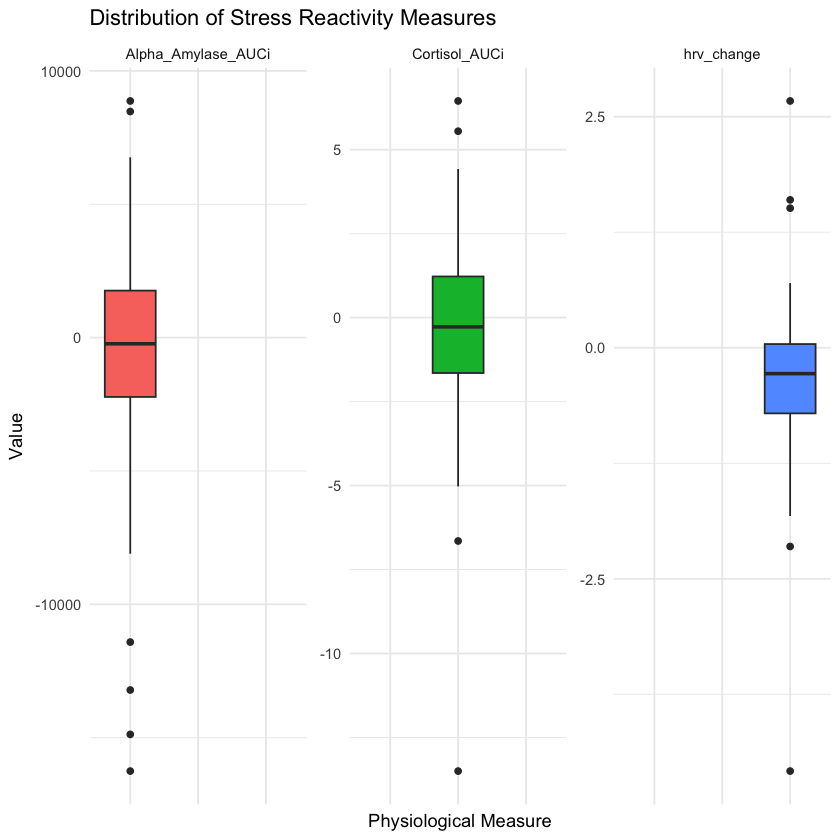

In [90]:
plot_data_long <- combined_data_final %>%
  select(hrv_change, Alpha_Amylase_AUCi, Cortisol_AUCi) %>%
  pivot_longer(
    cols = everything(), 
    names_to = "measure", 
    values_to = "value"
  )

ggplot(plot_data_long, aes(x = measure, y = value, fill = measure)) +
  geom_boxplot() +
  facet_wrap(~ measure, scales = "free_y") + 
  labs(
    title = "Distribution of Stress Reactivity Measures",
    x = "Physiological Measure",
    y = "Value"
  ) +
  theme_minimal() +
  theme(
    legend.position = "none",      
    axis.text.x = element_blank(), 
    axis.ticks.x = element_blank() 
  )
  
summary_stats <- combined_data_final %>%
  summarise(
    mean_hrv_change = mean(hrv_change, na.rm = TRUE),
    sd_hrv_change = sd(hrv_change, na.rm = TRUE),
    
    mean_alpha_amylase = mean(Alpha_Amylase_AUCi, na.rm = TRUE),
    sd_alpha_amylase = sd(Alpha_Amylase_AUCi, na.rm = TRUE),
    
    mean_cortisol = mean(Cortisol_AUCi, na.rm = TRUE),
    sd_cortisol = sd(Cortisol_AUCi, na.rm = TRUE)
  )

# Print the summary statistics table
summary_stats

Interestingly, the average of the cortisol and hrv_change are very close to zero. This suggests that drastic changes in these two measures from baseline to acute stress are rare across the study's population. I also notice that there might be some outliers for these measures, especially in the alpha amylase measure. This measure also has the greatest variability among the three measures as it has a high standard deviation. I am predicting that because of this, this measure will be the most influential in determining different profiles of stress responsiveness across these individuals. For this analysis, I will not be removing any outliers and will be using all participants in the analysis.

## Dimensionality Reduction (PCA)

## Question

I want to ask the question: What are the dominant underlying patterns that characterize individual differences in multi-system physiological stress reactivity?

I believe a PCA approach would be appropriate to identify these patterns from the dataset since we have more than 2 variables. I hope the PCA can simplify the complex, three-dimensional physiological data into fewer dimensions. After reducing the dimensions, a scatter plot of the principal components can show if certain subjects clump together. This would suggest the existence of distinct stress reactivity profiles within the study's population.

In [59]:
# Scale and center the data
scaled_data <- combined_data_final %>%
  select(hrv_change, Alpha_Amylase_AUCi, Cortisol_AUCi) %>%
  na.omit() %>%
  scale()


In [60]:
pca_result <- prcomp(scaled_data)
summary(pca_result)

Importance of components:
                          PC1    PC2    PC3
Standard deviation     1.1029 1.0326 0.8469
Proportion of Variance 0.4055 0.3554 0.2391
Cumulative Proportion  0.4055 0.7609 1.0000

This shows that PC1 explains 40.55% of the variance in the data and PC2 explains 35.54%. Together, the first two principal components explain 76.09% of the total variance. This means that we can capture most of the important patterns in the data using just these two dimensions.

In [61]:
rotation <- (pca_result$rotation)
rotation

,PC1,PC2,PC3
hrv_change,-0.7477883,-0.1010804,0.6561977
Alpha_Amylase_AUCi,0.3115297,0.8193711,0.4812278
Cortisol_AUCi,-0.5863122,0.5642816,-0.5812266


This rotation matrix is helpful to understand what each principal component represents in terms of the original variables.

PC1: This consists mostly of an opposition between HPA axis/parasympathetic activity and sympathetic activity. Individuals with high scores on PC1 will tend to have low HRV change (less parasympathetic withdrawal) and low cortisol reactivity, but slightly higher alpha-amylase reactivity. On the other hand, individuals with low scores on PC1 show high cortisol and high HRV change.

PC2: PC2 primarily captures sympathetic and HPA axis co-activation. Individuals with high scores on PC2 show strong increases in both alpha-amylase and cortisol, with little involvement from HRV.

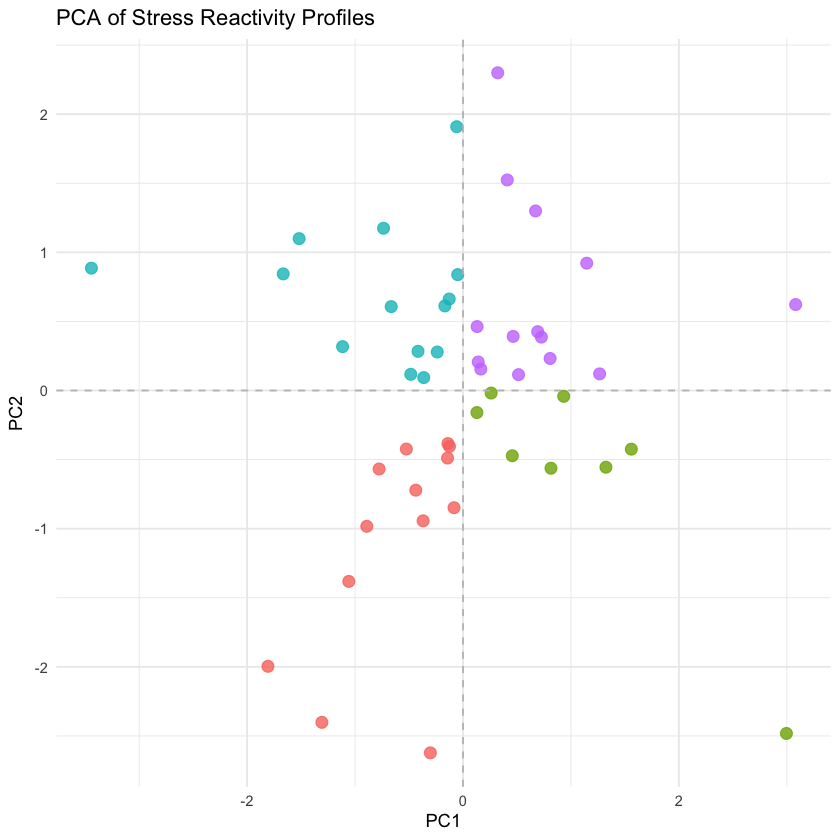

In [71]:
pca_scores <- as.data.frame(pca_result$x)
combined_data_final$PC1 <- pca_scores$PC1
combined_data_final$PC2 <- pca_scores$PC2

# Define the quadrants based on PC1 and PC2 scores
combined_data_final <- combined_data_final %>%
  mutate(quadrant = case_when(
    PC1 >= 0 & PC2 >= 0 ~ "Top-Right (Multi-System)",
    PC1 < 0  & PC2 >= 0 ~ "Top-Left (Sympathetic-Dominant)",
    PC1 < 0  & PC2 < 0  ~ "Bottom-Left (Low Reactors)",
    PC1 >= 0 & PC2 < 0  ~ "Bottom-Right (HPA/PNS-Dominant)"
  ))

ggplot(combined_data_final, aes(x = PC1, y = PC2, color = quadrant)) +
  geom_point(alpha = 0.8, size = 3) +
  theme_minimal() +
  labs(
    title = "PCA of Stress Reactivity Profiles",
    x = "PC1",
    y = "PC2",
    color = "Reactivity Profile"
  ) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "grey") +
  geom_vline(xintercept = 0, linetype = "dashed", color = "grey") +
  theme(legend.position = "none")

One way you could interpret this plot is that each quadrant represents 4 different general types of stress responders. 

- Top-Right Quadrant (High PC1, High PC2): These individuals show high reactivity across the board. They have high scores on PC2, indicating strong sympathetic and HPA co-activation. However, they also have high scores on PC1 meaning that they do not have much change in their parasympathetic response, meaning they react to stress mostly through sympathetic and HPA activation.

- Bottom-Right Quadrant (High PC1, Low PC2): These individuals have low scores on PC2, meaning they do not show strong co-activation of the sympathetic and HPA systems. Their high scores on PC1 indicate a profile characterized by low cortisol and low HRV change meaning that they did not show a significant stress response.

- Top-Left Quadrant (Low PC1, High PC2): These subjects have high scores on PC2 (high sympathetic and HPA activation) but low scores on PC1. The low PC1 score points towards high cortisol and high HRV change which means these individuals react to stress through both parasympathetic withdrawal and sympathetic and HPA activation. These participants are very sensitive to stress.

- Bottom-Left Quadrant (Low PC1, Low PC2): These individuals have low scores on both components, suggesting they have a generally blunted or low-level response across all three physiological systems.

Next, I want to conduct a t-SNE on this data. t-SNE goes further by focusing on local neighborhood structure, which helps separate clusters that are not linearly aligned.

In [73]:
pca_scores <- as.data.frame(pca_result$x)
set.seed(123) 
tsne_out <- Rtsne(pca_scores, dims = 2, perplexity = 10, check_duplicates = FALSE)

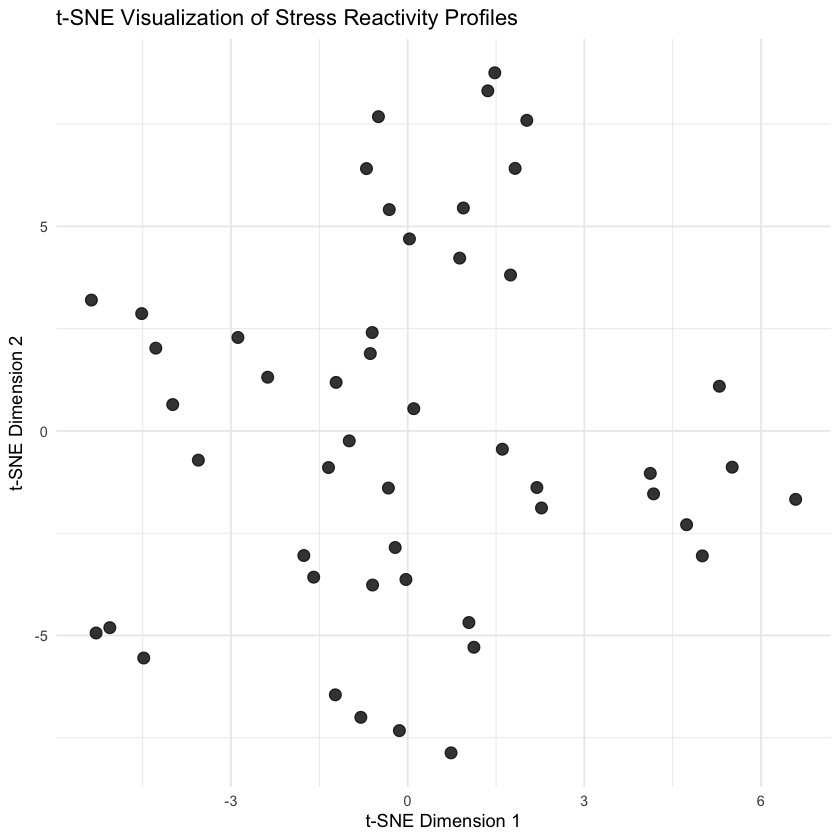

In [75]:
tsne_df <- as.data.frame(tsne_out$Y)
colnames(tsne_df) <- c("TSNE1", "TSNE2")

ggplot(tsne_df, aes(x = TSNE1, y = TSNE2)) +
  geom_point(size = 3, alpha = 0.8) +
  labs(
    title = "t-SNE Visualization of Stress Reactivity Profiles",
    x = "t-SNE Dimension 1",
    y = "t-SNE Dimension 2"
  ) +
  theme_minimal()

This plot shows loose groupings of the data, but they are not sharply separated. I see a few clusters like the one toward the upper center, the one toward the lower left, and the one toward the right side. Each cluster may represent a different profile of stress responsiveness in these adolescents.

Overall, the PCA analysis shows that some very slight clusters may be present, but the groupings are not that distinct from each other, so it's difficult to draw clear conclusions about distinct physiological response profiles. Instead of PCA, the next step would be to try a K-means clustering approach to identify more distinct groups. 

## Question

This might help me answer the questions:

- How many distinct "types" of stress responders are in my sample?
- What does the average stress profile (in terms of HRV, cortisol, and alpha-amylase) look like for each type?

## Clustering Analysis

I am going to be clustering my original scaled data. Then I am going to visualize the clusters generated by the K-means algorithm on both the t-SNE and PCA plots to see if I can identify more distinct stress response profiles. I am going to try k=3 clusters first because that is the number of groups I hypothesize exist based on the literature and the adaptive calibration model that predicts three distinct stress response types: adaptive, blunted, and hyper-responsive.

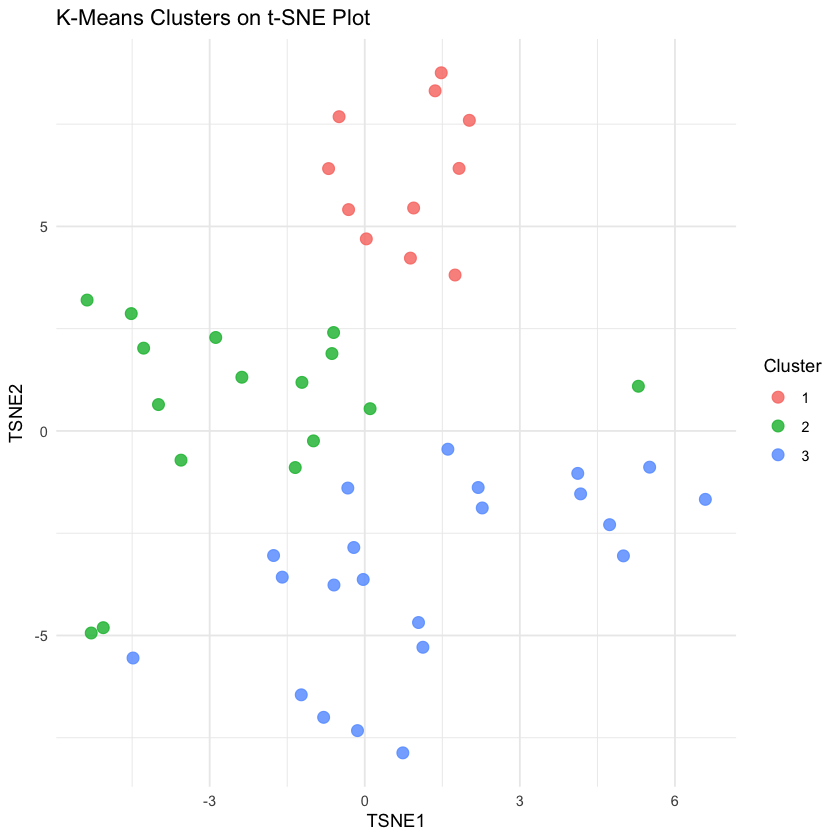

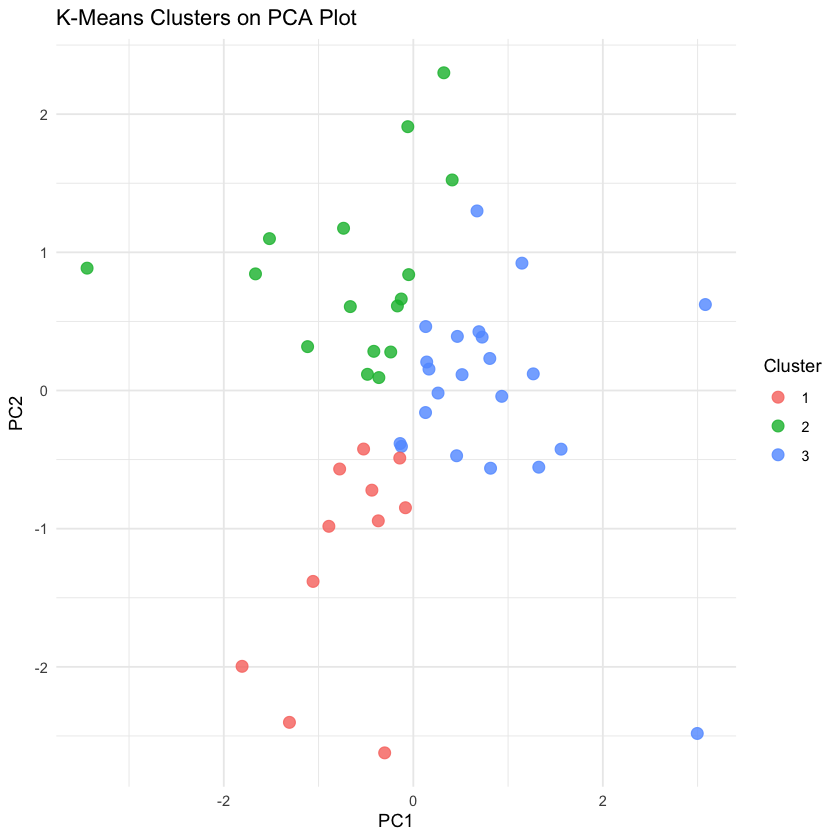

In [82]:
# Set the number of clusters
k <- 3

set.seed(123)
kmeans_result_3 <- kmeans(scaled_data, centers = k, nstart = 25)

# Add cluster assignments to your t-SNE dataframe
tsne_df$cluster <- as.factor(kmeans_result_3$cluster)

# Add cluster assignments to your PCA dataframe
combined_data_final_complete$cluster <- as.factor(kmeans_result_3$cluster)

# Plot on t-SNE map
ggplot(tsne_df, aes(x = TSNE1, y = TSNE2, color = cluster)) +
  geom_point(size = 3, alpha = 0.8) +
  labs(title = "K-Means Clusters on t-SNE Plot", color = "Cluster") +
  theme_minimal()

# Plot on PCA map
ggplot(combined_data_final_complete, aes(x = PC1, y = PC2, color = cluster)) +
  geom_point(size = 3, alpha = 0.8) +
  labs(title = "K-Means Clusters on PCA Plot", color = "Cluster") +
  theme_minimal()

I also wanted to see what would happen if I specified 4 clusters instead because when I was analyzing the PCA plot originally, I split the plot into quadrants and defined 4 profiles in that way. Let me try that here.

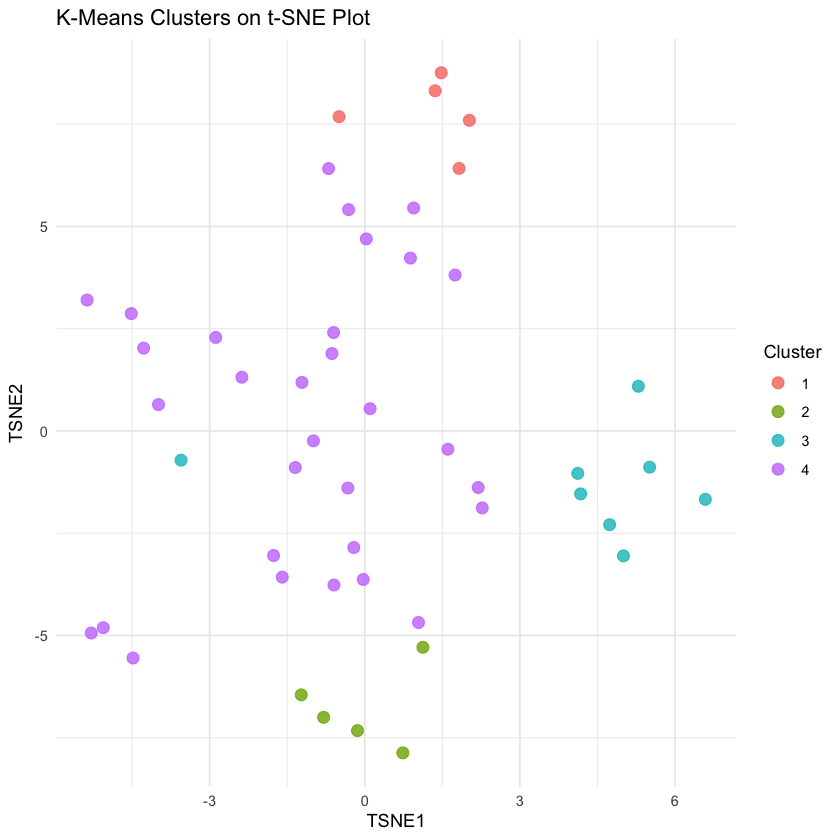

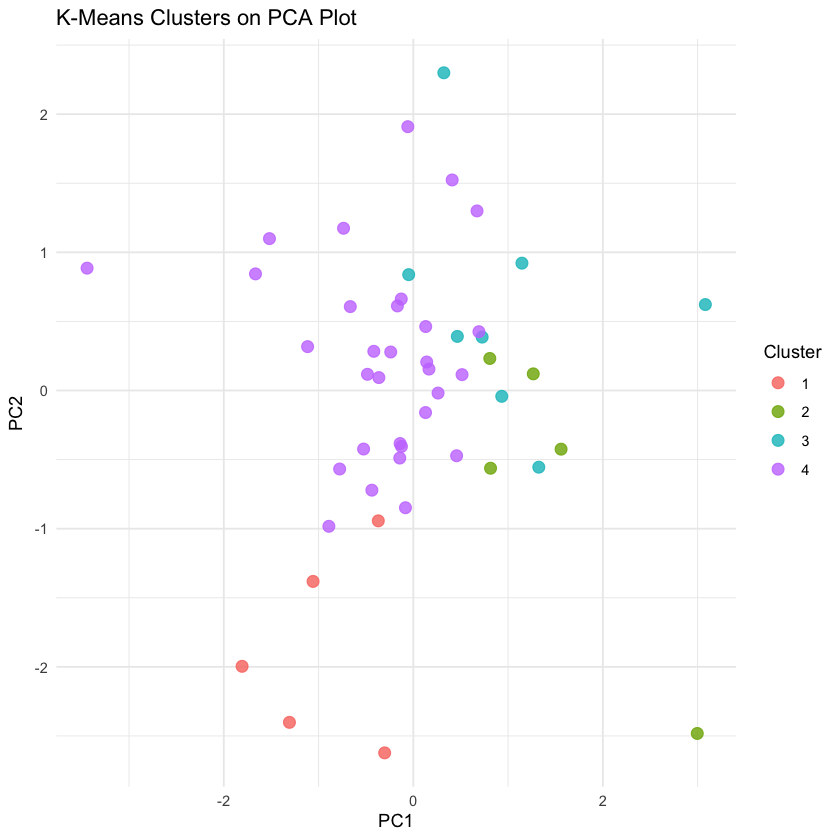

In [83]:
# Set the number of clusters
k <- 4

set.seed(123)
kmeans_result_4 <- kmeans(scaled_data, centers = k, nstart = 25)

# Add cluster assignments to your t-SNE dataframe
tsne_df$cluster <- as.factor(kmeans_result_4$cluster)

# Add cluster assignments to your PCA dataframe
combined_data_final_complete$cluster <- as.factor(kmeans_result_4$cluster)

# Plot on t-SNE map
ggplot(tsne_df, aes(x = TSNE1, y = TSNE2, color = cluster)) +
  geom_point(size = 3, alpha = 0.8) +
  labs(title = "K-Means Clusters on t-SNE Plot", color = "Cluster") +
  theme_minimal()

# Plot on PCA map
ggplot(combined_data_final_complete, aes(x = PC1, y = PC2, color = cluster)) +
  geom_point(size = 3, alpha = 0.8) +
  labs(title = "K-Means Clusters on PCA Plot", color = "Cluster") +
  theme_minimal()

After this, it looks like using 3 clusters gives a better separation of the data points than 4. I think I can say now that my answer to: How many distinct "types" of stress responders are in my sample? is 3. Now I want to answer: What does the average stress profile (in terms of HRV, cortisol, and alpha-amylase) look like for each type? I am going to do this by creating box plots to show the levels of the original three stress measures for each cluster. 

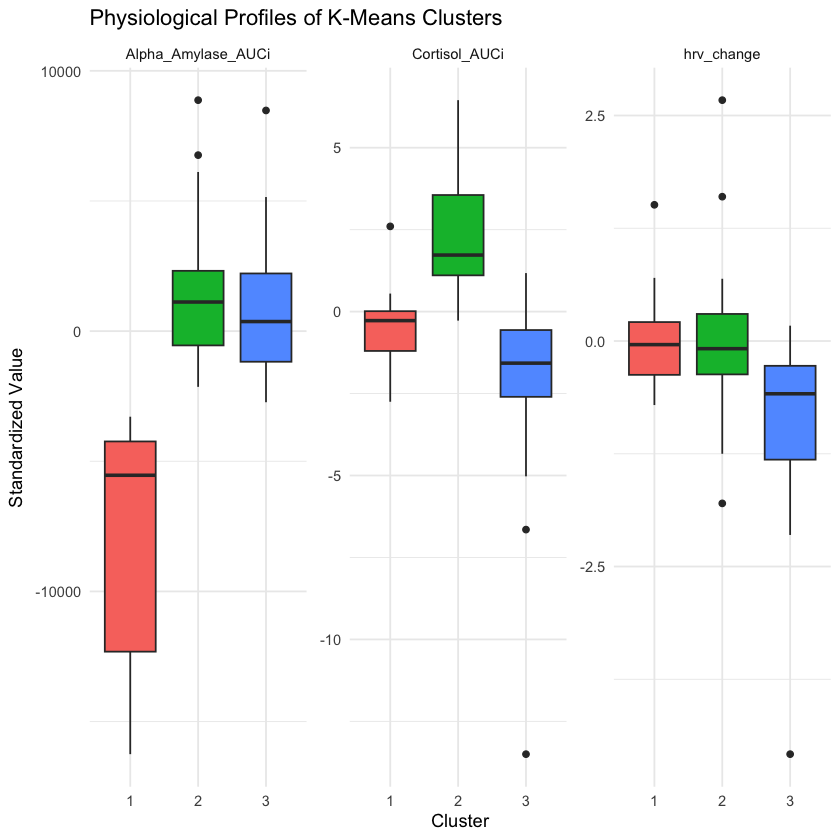

In [85]:
# Add the cluster assignments back to the original (complete) data
combined_data_final_complete$cluster <- as.factor(kmeans_result_3$cluster)

# Reshape the data into a long format 
plot_data_long <- combined_data_final_complete %>%
  select(cluster, hrv_change, Alpha_Amylase_AUCi, Cortisol_AUCi) %>%
  pivot_longer(cols = -cluster, names_to = "measure", values_to = "value")

# Create the boxplots
ggplot(plot_data_long, aes(x = cluster, y = value, fill = cluster)) +
  geom_boxplot() +
  facet_wrap(~ measure, scales = "free_y") + 
  labs(
    title = "Physiological Profiles of K-Means Clusters",
    x = "Cluster",
    y = "Standardized Value"
  ) +
  theme_minimal() +
  theme(legend.position = "none") 

These plots answer the question: What does the average stress profile (in terms of HRV, cortisol, and alpha-amylase) look like for each type?

### Cluster 1 (Red): The Blunted / Atypical Responders
- **Alpha-Amylase**: This is the most interesting feature in the cluster. This group shows a strong negative AUCi, meaning their sympathetic nervous system activity decreased significantly during the stress task. This is an atypical response.
- **Cortisol**: Their cortisol response is centered around zero, indicating a blunted or non-existent HPA-axis response.
- **HRV Change**: Their HRV change is also centered near zero, suggesting minimal change in parasympathetic activity.
- **Summary**: This is a unique group characterized by a general lack of physiological reactivity and an unusual decrease in sympathetic tone.

## Cluster 2 (Green): The Strong HPA-Axis Responders
- **Cortisol**: This group has a very strong and positive cortisol AUCi, making them clear HPA-axis hyper-responders.
- **Alpha-Amylase**: They also show a moderate positive alpha-amylase response which suggests sympathetic activation.
- **HRV Change**: Their HRV change is minimal, centered around zero.
- **Summary**: This is a classic high-stress reactor profile. They are defined by a powerful cortisol response, coupled with a solid sympathetic response.

## Cluster 3 (Blue): The Autonomic Nervous System Responders
- **HRV Change**: This group's defining feature is a strong negative HRV change, indicating significant parasympathetic withdrawal which is a classic sign of a stress response.
- **Alpha-Amylase**: They also show a moderate positive alpha-amylase response, indicating sympathetic activation.
- **Cortisol**: In contrast, their cortisol response is negative or blunted.
- **Summary**: This group's stress response is almost entirely driven by the autonomic nervous system (both sympathetic activation and parasympathetic withdrawal), with very little involvement from the HPA axis (cortisol).




## Future Steps

There are several future steps I could take from this analysis:

- Perform PCA and t-SNE on the original dataset which includes the sAA and cortisol measurements at each time point. Maybe, the measurement at a certain time point is more predictive of the different profiles than the AUCi. 
- Use some other data I have about these participants to find out what factors predict which profile they belong to. For example, I have JVQ scores for each participant which measures how much abuse and victimization they experienced as a child. I could use this data to see if certain profiles are associated with higher or lower levels of childhood adversity.
- Different participants came in at different times to complete the experiment and your bodies natural cortisol levels vary through the day. This might affect the cortisol data, so it would be interesting to redo the cortisol AUCi after I standardize all the raw cortisol measurements based on the time of day the sample was taken for each participant.